# **MangoFruitDDS Statistics, Analysis, Prediction**
*Made by Rachit Srivastava

 Code to check Database from google drive


In [4]:
from google.colab import drive
import os

drive.mount('/content/drive')

gdrive_folder = "/content/drive/MyDrive/Colab Notebooks/SenMangoFruitDDS_bgremoved"

if os.path.exists(gdrive_folder):
    print("Dataset is available at:", gdrive_folder)
else:
    print("Dataset folder not found. Re-download might be needed.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset is available at: /content/drive/MyDrive/Colab Notebooks/SenMangoFruitDDS_bgremoved


Code to download and save dataset in google drive if not available.

In [ ]:
import kagglehub
import shutil
import os


path = kagglehub.dataset_download("warcoder/mangofruitdds")

desired_folder = "/content/my_desired_folder"

os.makedirs(desired_folder, exist_ok=True)

shutil.move(path, desired_folder)

print("Dataset moved to:", desired_folder)





> **Logistic Regression**




Training data shape: (670, 128, 128, 3) , Training labels shape: (670, 5)

Testing data shape: (168, 128, 128, 3) , Testing labels shape: (168, 5)
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 519ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step

Extracted feature shape (Train): (670, 1280)

Extracted feature shape (Test): (168, 1280)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Confusion Matrix:
[[20  2 10  0  1]
 [ 1 22  2  0  1]
 [ 9  1 25  0  2]
 [ 1  0  0 40  0]
 [ 2  0  1  0 28]]

Classification Report:
                 precision    recall  f1-score   support

     Alternaria       0.61      0.61      0.61        33
    Anthracnose       0.88      0.85      0.86        26
Black Mould Rot       0.66      0.68      0.67        37
        Healthy       1.00      0.98      0.99        41
   Stem and Rot       0.88      0.90      0.89        31

       accuracy                           0.80       168
      macro avg       0.80      0.80      0.80       168
   weighted avg       0.81      0.80      0.80       168



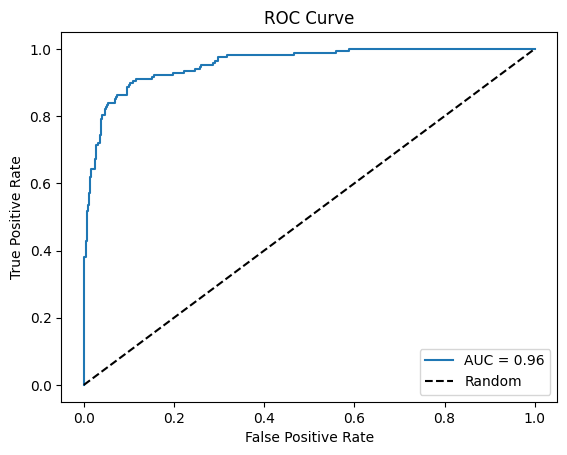

<Figure size 640x480 with 0 Axes>

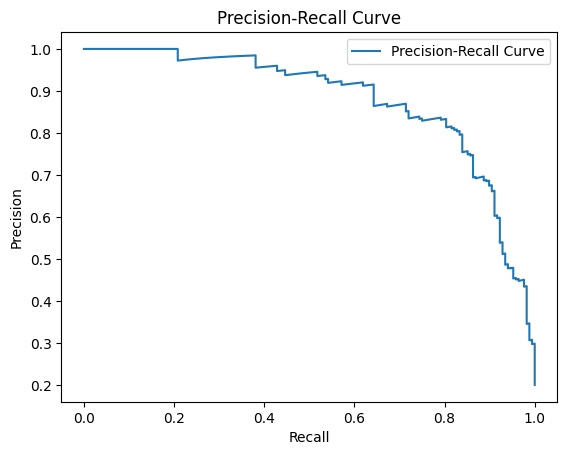

<Figure size 640x480 with 0 Axes>

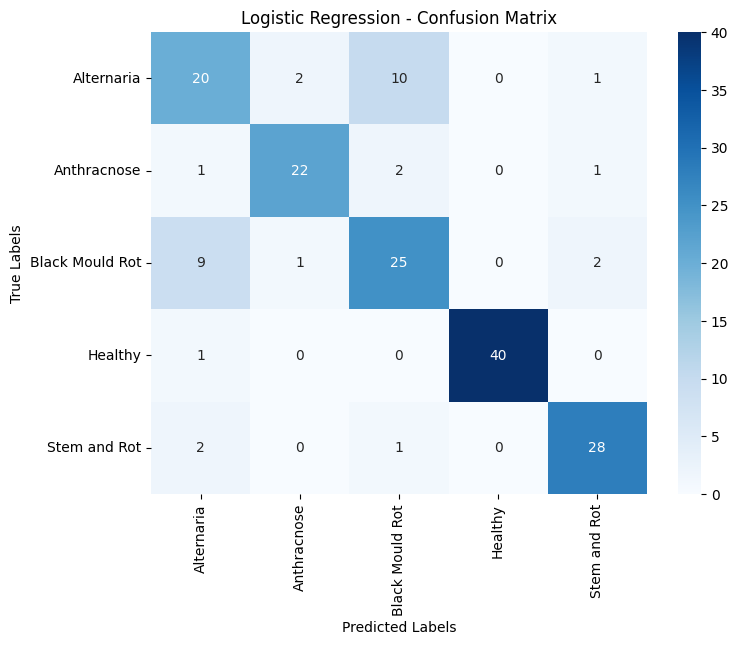

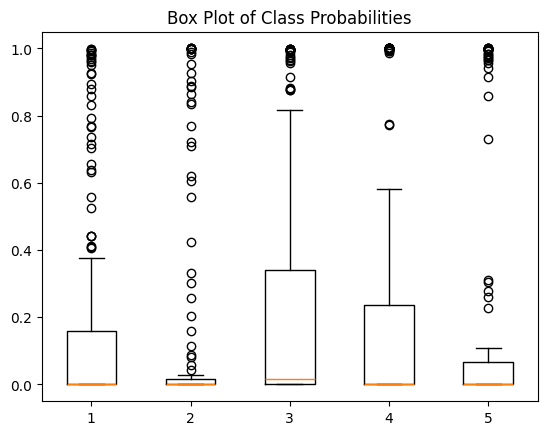

<Figure size 640x480 with 0 Axes>

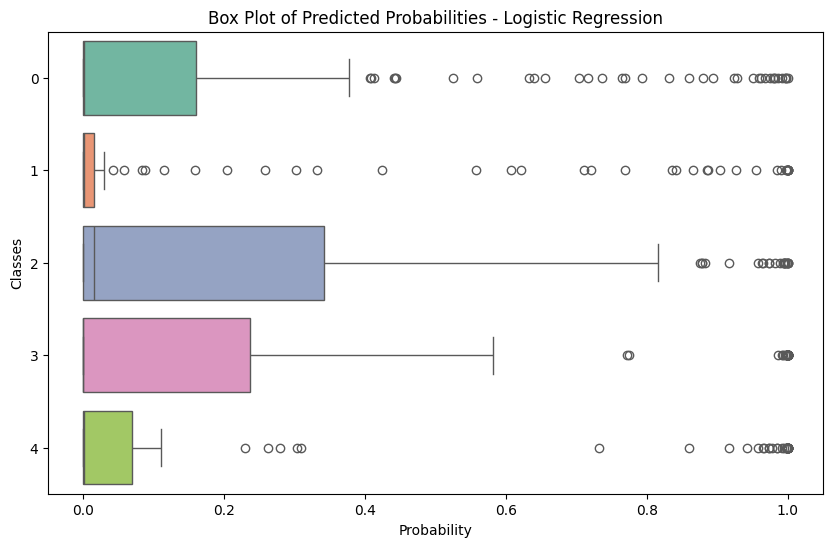

In [10]:
import os
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Dataset Path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/SenMangoFruitDDS_bgremoved"  # Update this to your dataset folder

# Image Parameters
image_size = (128, 128)  # Resizing all images to 128x128
batch_size = 32

# Load Images and Labels
datagen = ImageDataGenerator(rescale=1.0 / 255.0)
data = []
labels = []

# Loop through each folder (class)
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                # Load and resize image
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                data.append(img_array)
                labels.append(class_folder)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

# Convert data to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Encode Labels
encoder = LabelBinarizer()
labels = encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

print("\nTraining data shape:", X_train.shape, ", Training labels shape:", y_train.shape)
print("\nTesting data shape:", X_test.shape, ", Testing labels shape:", y_test.shape)

# Load pre-trained MobileNetV2 model for feature extraction
base_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(128, 128, 3))

# Preprocess images using MobileNetV2 preprocess function
X_train_preprocessed = preprocess_input(X_train)
X_test_preprocessed = preprocess_input(X_test)

# Extract features
X_train_features = base_model.predict(X_train_preprocessed)
X_test_features = base_model.predict(X_test_preprocessed)

print("\nExtracted feature shape (Train):", X_train_features.shape)
print("\nExtracted feature shape (Test):", X_test_features.shape)

# Convert one-hot encoded labels to 1D array of class indices
y_train_indices = y_train.argmax(axis=1)
y_test_indices = y_test.argmax(axis=1)

# Train Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
logistic_model.fit(X_train_features, y_train_indices)

# Predict on Test Data
y_pred_indices = logistic_model.predict(X_test_features)
y_pred_proba = logistic_model.predict_proba(X_test_features)

# Evaluation Metrics
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_indices, y_pred_indices))

print("\nClassification Report:")
print(classification_report(y_test_indices, y_pred_indices, target_names=encoder.classes_))

# AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

plt.figure()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test.ravel(), y_pred_proba.ravel())

plt.figure()
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


plt.figure()

# Get the predicted class labels for Logistic Regression
y_pred_logistic_class = np.argmax(y_pred_proba, axis=1)

# Compute confusion matrix for Logistic Regression
cm_logistic = confusion_matrix(y_test_indices, y_pred_logistic_class)

# Plot confusion matrix as heatmap for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logistic, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


plt.figure()

# Box Plot of Probabilities
plt.boxplot(y_pred_proba)
plt.title("Box Plot of Class Probabilities")
plt.show()


plt.figure()

# Function to plot boxplot
def plot_boxplot(probabilities, model_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=probabilities, orient="h", palette="Set2")
    plt.title(f"Box Plot of Predicted Probabilities - {model_name}")
    plt.xlabel("Probability")
    plt.ylabel("Classes")
    plt.show()

# Plot boxplot for Logistic Regression probabilities
if 'logistic_model' in globals():
    logistic_probabilities = logistic_model.predict_proba(X_test_features)
    plot_boxplot(logistic_probabilities, "Logistic Regression")




> **Ridge and Lasso Regression**



Ridge Regression - Confusion Matrix:
[[ 8 13 10  2  0]
 [ 5  8 12  0  1]
 [ 2  9 17  9  0]
 [ 1  3  6 23  8]
 [ 2  0  4  9 16]]

Ridge Regression - Classification Report:
                 precision    recall  f1-score   support

     Alternaria       0.44      0.24      0.31        33
    Anthracnose       0.24      0.31      0.27        26
Black Mould Rot       0.35      0.46      0.40        37
        Healthy       0.53      0.56      0.55        41
   Stem and Rot       0.64      0.52      0.57        31

       accuracy                           0.43       168
      macro avg       0.44      0.42      0.42       168
   weighted avg       0.45      0.43      0.43       168

Lasso Regression - Confusion Matrix:
[[ 2 18 11  2  0]
 [ 0 11 12  3  0]
 [ 1 15 15  6  0]
 [ 0  0 10 31  0]
 [ 0  2  6 18  5]]

Lasso Regression - Classification Report:
                 precision    recall  f1-score   support

     Alternaria       0.67      0.06      0.11        33
    Anthracnose       0.24 

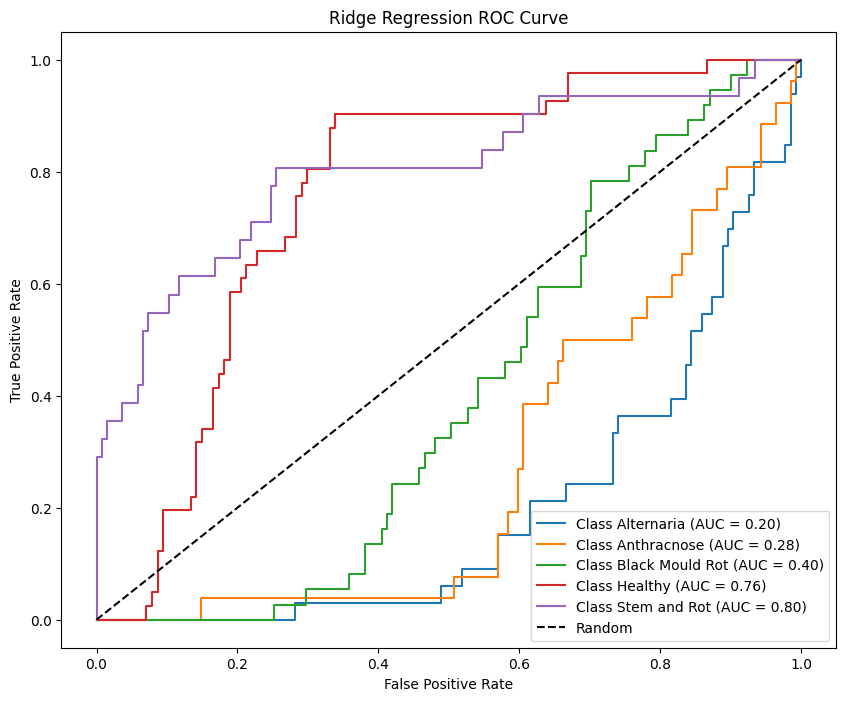

<Figure size 640x480 with 0 Axes>

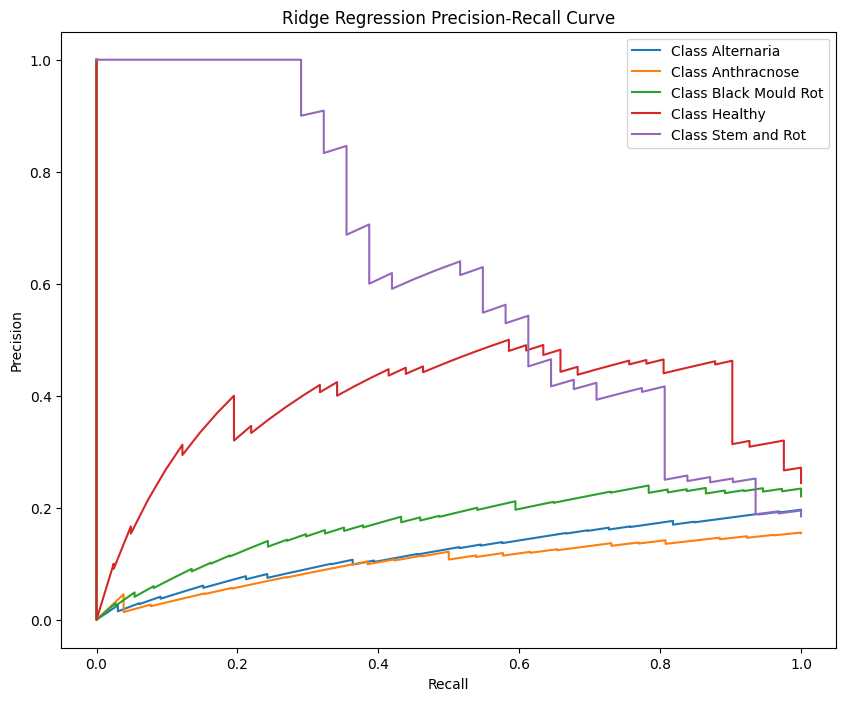

<Figure size 640x480 with 0 Axes>

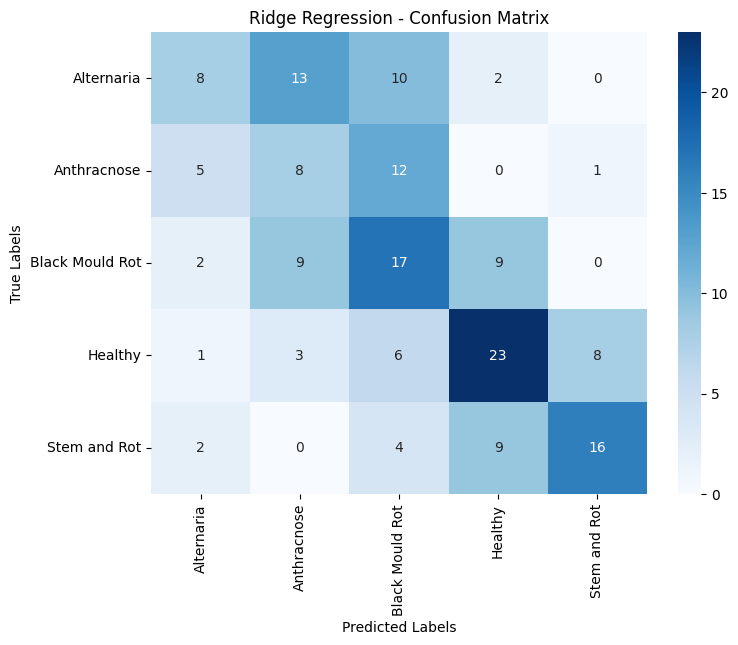

<ipython-input-7-6c9adbd36167>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=probabilities, orient="h", palette="Set2")


<Figure size 640x480 with 0 Axes>

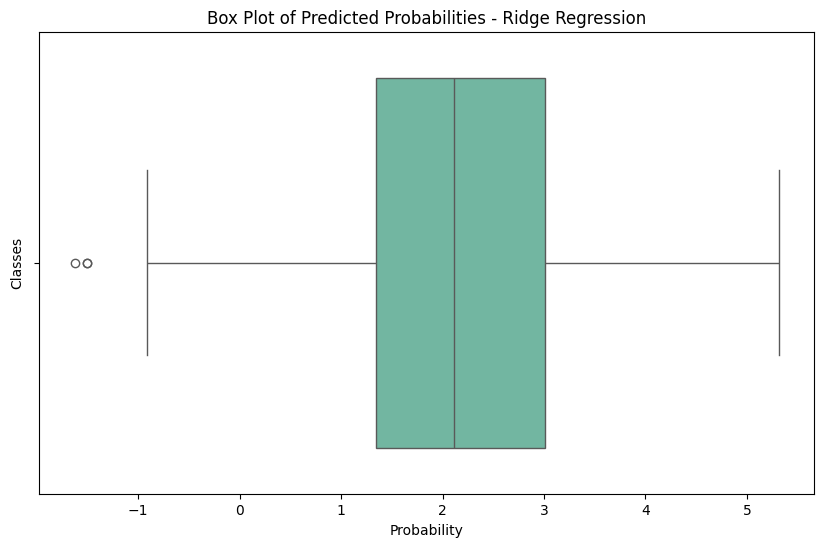

<ipython-input-7-6c9adbd36167>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=probabilities, orient="h", palette="Set2")


<Figure size 640x480 with 0 Axes>

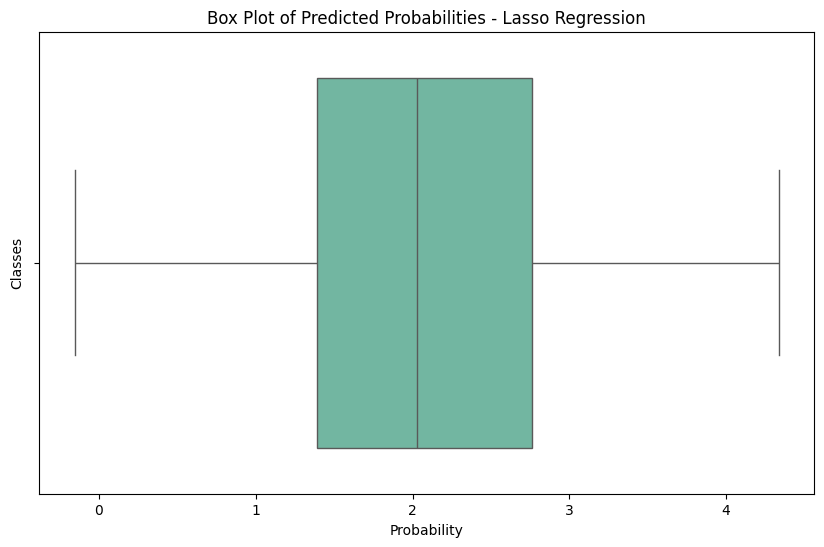

<Figure size 640x480 with 0 Axes>

In [7]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Ridge Regression
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_features, y_train_indices)

# Predict using Ridge
y_pred_ridge = ridge_model.predict(X_test_features)
y_pred_ridge_class = np.round(y_pred_ridge).astype(int)  # Round predictions
y_pred_ridge_class = np.clip(y_pred_ridge_class, 0, len(encoder.classes_) - 1)

# Lasso Regression
lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train_features, y_train_indices)

# Predict using Lasso
y_pred_lasso = lasso_model.predict(X_test_features)
y_pred_lasso_class = np.round(y_pred_lasso).astype(int)
y_pred_lasso_class = np.clip(y_pred_lasso_class, 0, len(encoder.classes_) - 1)

# Ridge Evaluation
print("Ridge Regression - Confusion Matrix:")
print(confusion_matrix(y_test_indices, y_pred_ridge_class))
print("\nRidge Regression - Classification Report:")
print(
    classification_report(
        y_test_indices,
        y_pred_ridge_class,
        target_names=encoder.classes_,
        zero_division=0
    )
)

# Lasso Evaluation
print("Lasso Regression - Confusion Matrix:")
print(confusion_matrix(y_test_indices, y_pred_lasso_class))
print("\nLasso Regression - Classification Report:")
print(
    classification_report(
        y_test_indices,
        y_pred_lasso_class,
        target_names=encoder.classes_,
        zero_division=0
    )
)

# ROC Curve and AUC for each class (Ridge)
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_ridge)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ridge Regression ROC Curve")
plt.legend()
plt.show()

plt.figure()

# Precision-Recall Curve for Ridge
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_ridge)
    plt.plot(recall, precision, label=f"Class {class_name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Ridge Regression Precision-Recall Curve")
plt.legend()
plt.show()

plt.figure()

# Compute confusion matrix for Ridge Regression
cm_ridge = confusion_matrix(y_test_indices, y_pred_ridge_class)

# Plot confusion matrix as heatmap for Ridge Regression
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ridge, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Ridge Regression - Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

plt.figure()

def plot_boxplot(probabilities, model_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=probabilities, orient="h", palette="Set2")
    plt.title(f"Box Plot of Predicted Probabilities - {model_name}")
    plt.xlabel("Probability")
    plt.ylabel("Classes")
    plt.show()

    plt.figure()

if 'ridge_model' in globals():
    ridge_probabilities = ridge_model.predict(X_test_features)
    plot_boxplot(ridge_probabilities, "Ridge Regression")

if 'lasso_model' in globals():
    lasso_probabilities = lasso_model.predict(X_test_features)
    plot_boxplot(lasso_probabilities, "Lasso Regression")





> **Naive Buyes**



Naive Bayes - Confusion Matrix:
[[20  2  7  0  4]
 [ 3 17  3  3  0]
 [17  4 12  1  3]
 [ 5  3  1 32  0]
 [ 3  6  6  0 16]]

Naive Bayes - Classification Report:
                 precision    recall  f1-score   support

     Alternaria       0.42      0.61      0.49        33
    Anthracnose       0.53      0.65      0.59        26
Black Mould Rot       0.41      0.32      0.36        37
        Healthy       0.89      0.78      0.83        41
   Stem and Rot       0.70      0.52      0.59        31

       accuracy                           0.58       168
      macro avg       0.59      0.58      0.57       168
   weighted avg       0.60      0.58      0.58       168



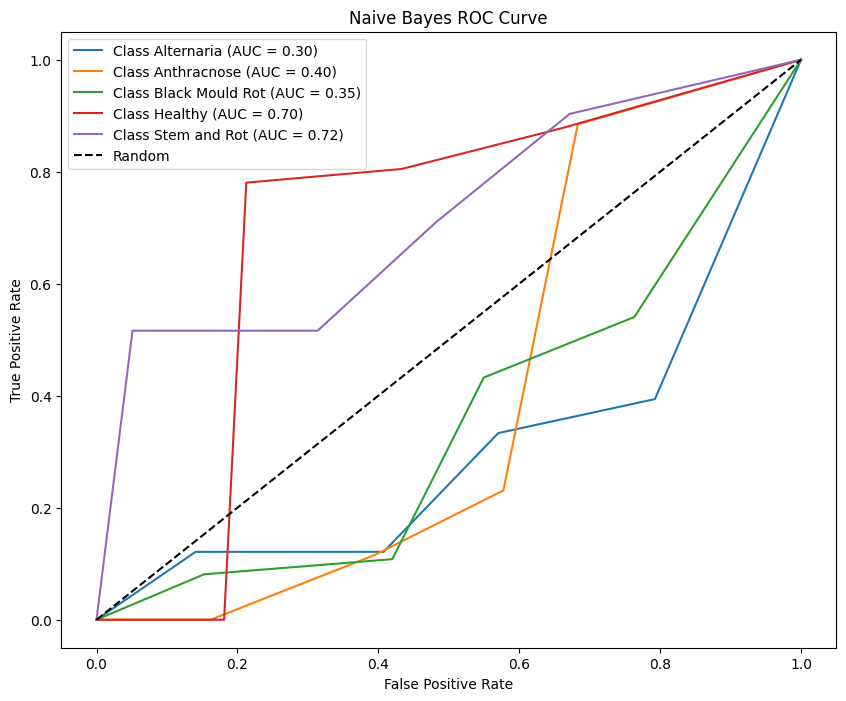

<Figure size 640x480 with 0 Axes>

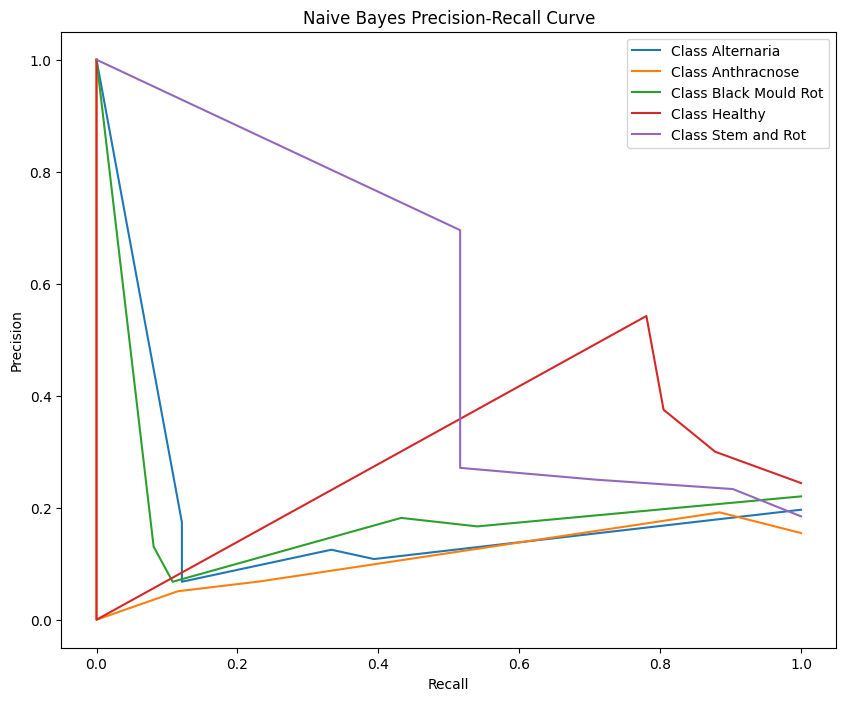

<Figure size 640x480 with 0 Axes>

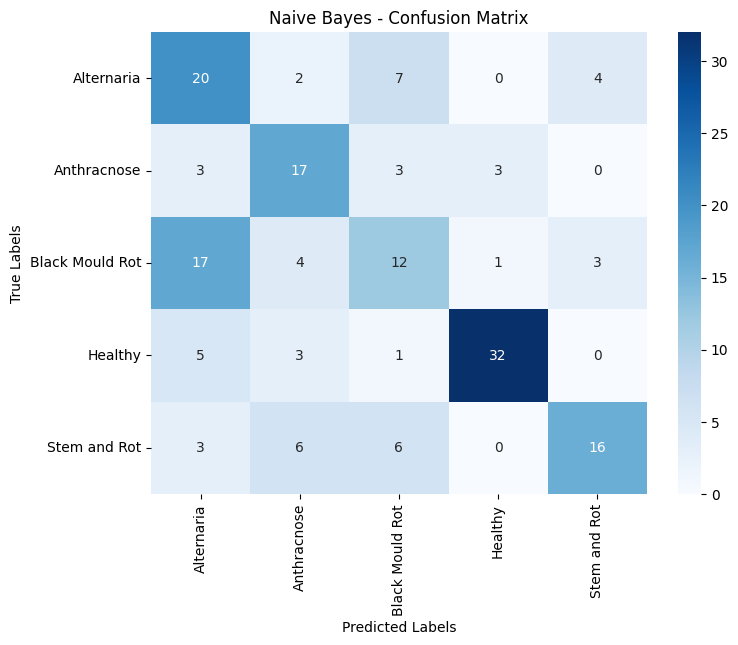

<Figure size 640x480 with 0 Axes>

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Naive Bayes Classifier
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train_features, y_train_indices)

# Predict using Naive Bayes
y_pred_naive = naive_bayes_model.predict(X_test_features)

# Evaluation
print("Naive Bayes - Confusion Matrix:")
print(confusion_matrix(y_test_indices, y_pred_naive))
print("\nNaive Bayes - Classification Report:")
print(classification_report(y_test_indices, y_pred_naive, target_names=encoder.classes_, zero_division=0))

# ROC Curve and AUC for Naive Bayes
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_naive)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Naive Bayes ROC Curve")
plt.legend()
plt.show()

plt.figure()

# Precision-Recall Curve for Naive Bayes
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_naive)
    plt.plot(recall, precision, label=f"Class {class_name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Naive Bayes Precision-Recall Curve")
plt.legend()
plt.show()

plt.figure()

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm_naive = confusion_matrix(y_test_indices, y_pred_naive)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_naive, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

plt.figure()
def plot_boxplot(probabilities, model_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=probabilities, orient="h", palette="Set2")
    plt.title(f"Box Plot of Predicted Probabilities - {model_name}")
    plt.xlabel("Probability")
    plt.ylabel("Classes")
    plt.show()

if 'naive_model' in globals():
    naive_probabilities = naive_model.predict_proba(X_test_features)
    plot_boxplot(naive_probabilities, "Naive Bayes")





> **K-nearest neighbour KNN**



Unique classes predicted by KNN: [0 1]
KNN - Classification Report:
              precision    recall  f1-score   support

  Alternaria       0.92      0.96      0.94       672
 Anthracnose       0.79      0.68      0.73       168

    accuracy                           0.90       840
   macro avg       0.86      0.82      0.83       840
weighted avg       0.90      0.90      0.90       840



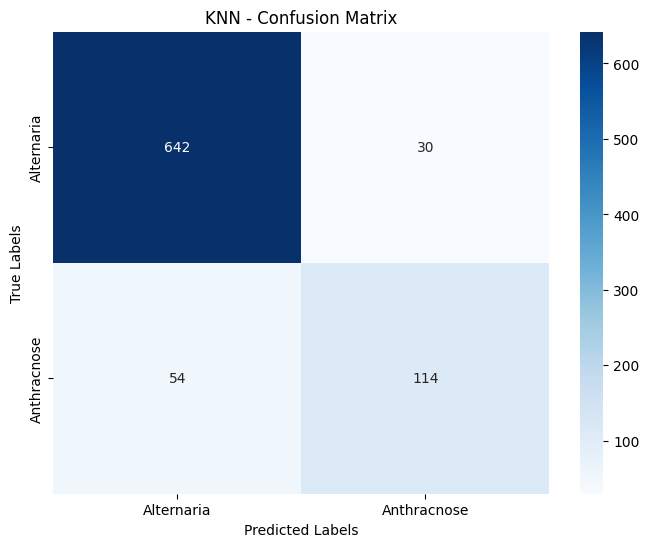

<Figure size 640x480 with 0 Axes>

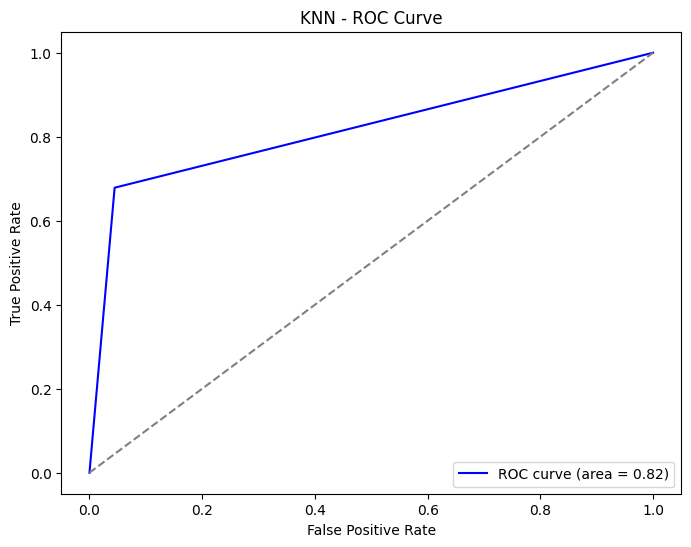

<Figure size 640x480 with 0 Axes>

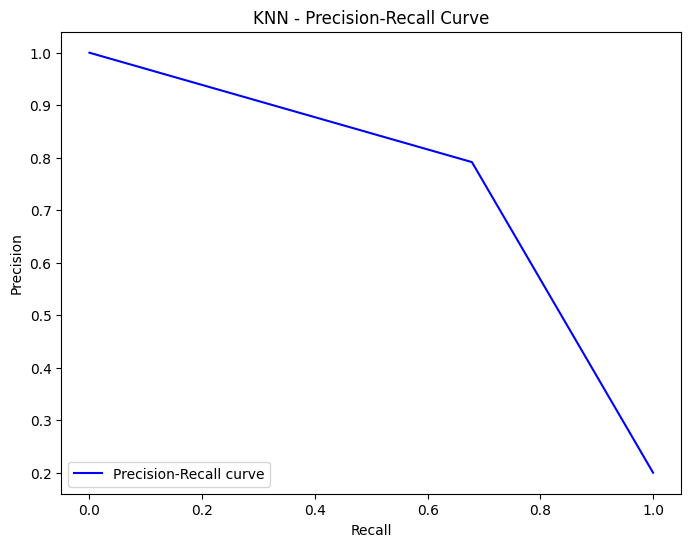

Unique classes in y_train: [0 1 2 3 4]
Unique classes in y_test: [0 1 2 3 4]
Number of classes in encoder: 5
Type of knn_probabilities: <class 'list'>
Shape of knn_probabilities: (5, 168, 2)
Adjusted shape of knn_probabilities: (840, 2)
Padding probabilities: 2 -> 5


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

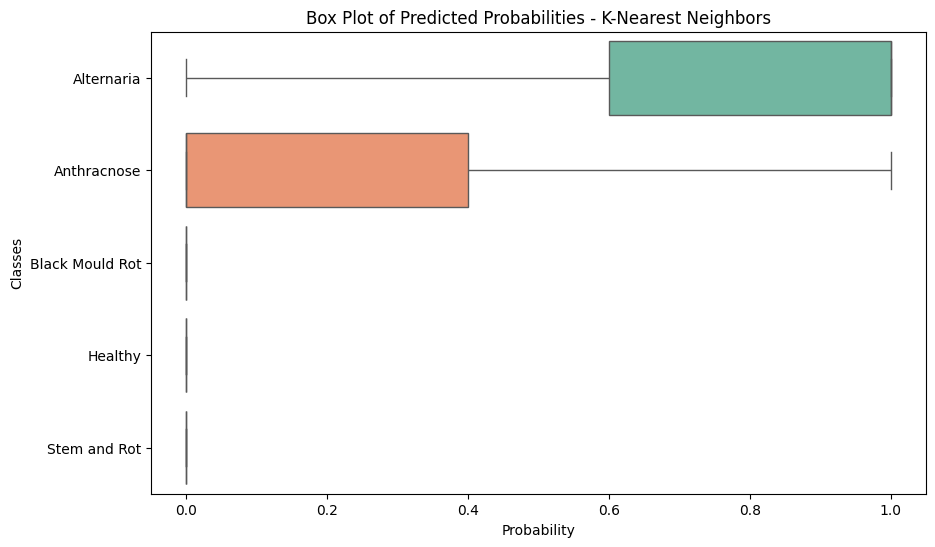

In [12]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
)
import pandas as pd

# Train KNN Model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_features, y_train)

# Predict on Test Data
y_pred_knn = knn_model.predict(X_test_features)

# Ensure both true labels and predictions are in 1D format
# Flatten the true labels
y_test_indices_flat = y_test.ravel()

# Flatten the predicted labels
y_pred_knn_flat = y_pred_knn.ravel()

# Check how many unique classes are predicted
print(f"Unique classes predicted by KNN: {np.unique(y_pred_knn_flat)}")

# Compute confusion matrix for KNN
cm_knn = confusion_matrix(y_test_indices_flat, y_pred_knn_flat)

# Print Classification Report
unique_classes = np.unique(y_test_indices_flat)
print("KNN - Classification Report:")
print(classification_report(y_test_indices_flat, y_pred_knn_flat, target_names=encoder.classes_[:len(unique_classes)]))

# Plot confusion matrix as heatmap for KNN
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_[:len(unique_classes)], yticklabels=encoder.classes_[:len(unique_classes)])
plt.title("KNN - Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

plt.figure()

# ROC Curve for KNN
knn_fpr, knn_tpr, _ = roc_curve(y_test_indices_flat, y_pred_knn_flat)
knn_auc = auc(knn_fpr, knn_tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(knn_fpr, knn_tpr, color='blue', label=f'ROC curve (area = {knn_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('KNN - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

plt.figure()

# Precision-Recall Curve for KNN
precision, recall, _ = precision_recall_curve(y_test_indices_flat, y_pred_knn_flat)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve')
plt.title('KNN - Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

plt.figure()

def plot_boxplot(probabilities, model_name, class_names):
    """
    Plots a boxplot for class probabilities.

    Args:
        probabilities (ndarray): The predicted probabilities (num_samples x num_classes).
        model_name (str): The name of the model (for the plot title).
        class_names (list): List of class names corresponding to the probabilities.
    """
    # Convert probabilities to a DataFrame for easier handling
    probabilities_df = pd.DataFrame(probabilities, columns=class_names)

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=probabilities_df, orient="h", palette="Set2")
    plt.title(f"Box Plot of Predicted Probabilities - {model_name}")
    plt.xlabel("Probability")
    plt.ylabel("Classes")
    plt.show()

plt.figure()

# Debugging Class Distribution
unique_y_train = np.unique(y_train.argmax(axis=1))
unique_y_test = np.unique(y_test.argmax(axis=1))

print(f"Unique classes in y_train: {unique_y_train}")
print(f"Unique classes in y_test: {unique_y_test}")
print(f"Number of classes in encoder: {len(encoder.classes_)}")

if 'knn_model' in globals():
    # Predict probabilities for KNN
    knn_probabilities = knn_model.predict_proba(X_test_features)

    # Debugging the type and shape of `knn_probabilities`
    print(f"Type of knn_probabilities: {type(knn_probabilities)}")
    print(f"Shape of knn_probabilities: {np.shape(knn_probabilities)}")

    # Convert to NumPy array if it's not already
    if not isinstance(knn_probabilities, np.ndarray):
        knn_probabilities = np.array(knn_probabilities)

    # Ensure `knn_probabilities` is 2D
    if len(knn_probabilities.shape) == 3:
        print("Warning: Unexpected 3D shape detected. Flattening last dimension.")
        knn_probabilities = knn_probabilities.reshape(-1, knn_probabilities.shape[-1])
    elif len(knn_probabilities.shape) != 2:
        raise ValueError(f"Unexpected shape for knn_probabilities: {knn_probabilities.shape}")

    # Debugging adjusted shape
    print(f"Adjusted shape of knn_probabilities: {knn_probabilities.shape}")

    # Number of true classes
    num_true_classes = len(encoder.classes_)

    # Padding probabilities if fewer columns than classes
    num_samples, num_pred_classes = knn_probabilities.shape
    if num_pred_classes < num_true_classes:
        print(f"Padding probabilities: {num_pred_classes} -> {num_true_classes}")
        padded_probabilities = np.zeros((num_samples, num_true_classes))
        padded_probabilities[:, :num_pred_classes] = knn_probabilities
        knn_probabilities = padded_probabilities

    # Plot boxplot
    plot_boxplot(knn_probabilities, "K-Nearest Neighbors", encoder.classes_)






> **Support Vector Machine (SVM)**



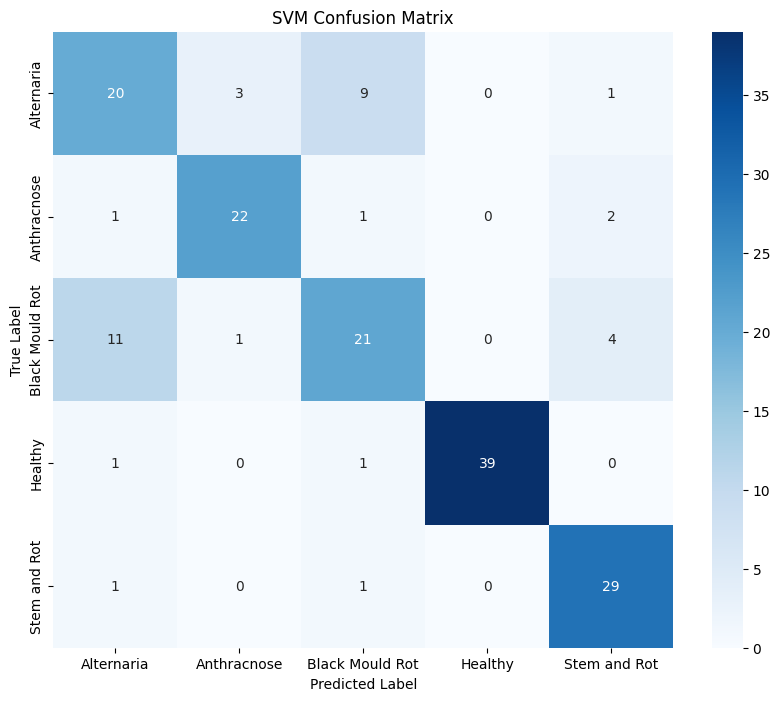

SVM - Classification Report:
                 precision    recall  f1-score   support

     Alternaria       0.59      0.61      0.60        33
    Anthracnose       0.85      0.85      0.85        26
Black Mould Rot       0.64      0.57      0.60        37
        Healthy       1.00      0.95      0.97        41
   Stem and Rot       0.81      0.94      0.87        31

       accuracy                           0.78       168
      macro avg       0.78      0.78      0.78       168
   weighted avg       0.78      0.78      0.78       168



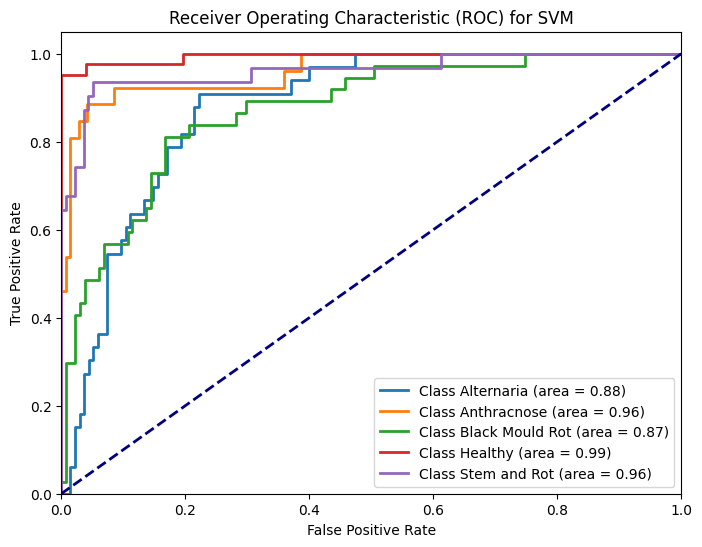

<Figure size 640x480 with 0 Axes>

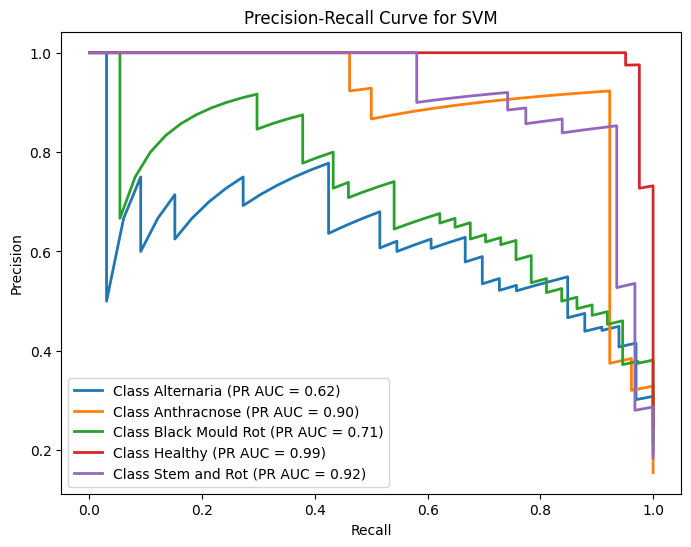

<Figure size 640x480 with 0 Axes>

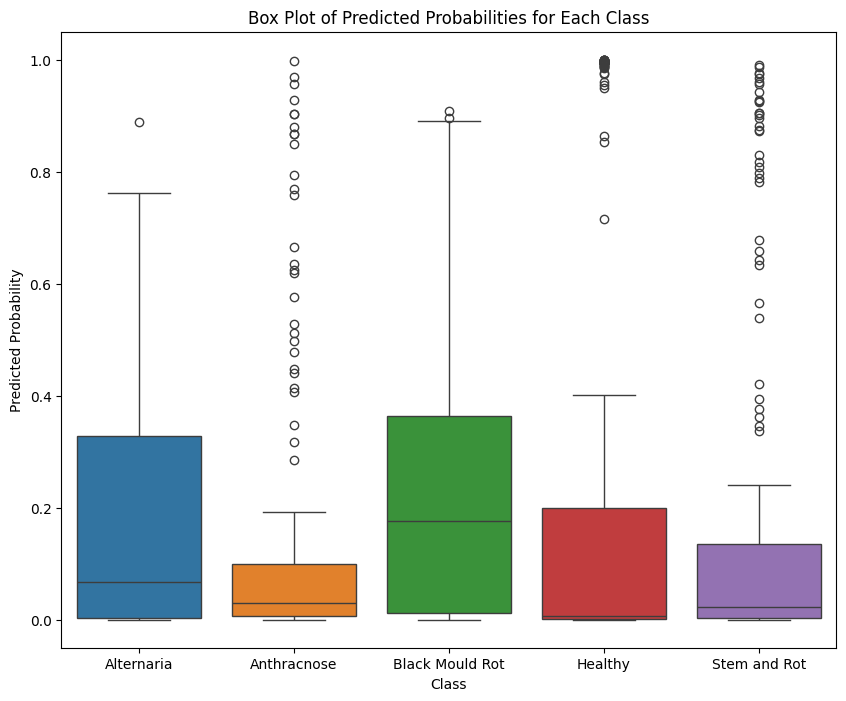

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Train Support Vector Machine (SVM)
svm_model = SVC(kernel='linear', decision_function_shape='ovr', probability=True)
svm_model.fit(X_train_features, y_train_indices)

# Predict using SVM
y_pred_svm = svm_model.predict(X_test_features)
y_pred_svm_prob = svm_model.predict_proba(X_test_features)

# Compute confusion matrix for SVM
cm_svm = confusion_matrix(y_test_indices, y_pred_svm)

# Plot confusion matrix as heatmap for SVM
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print Classification Report for SVM
print("SVM - Classification Report:")
print(classification_report(y_test_indices, y_pred_svm, target_names=encoder.classes_))

# Compute ROC Curve for SVM (for multi-class, we need to compute for each class)
fpr_svm, tpr_svm, roc_auc_svm = {}, {}, {}
for i in range(len(encoder.classes_)):
    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test_indices == i, svm_model.decision_function(X_test_features)[:, i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# Plot ROC Curve for SVM (for each class)
plt.figure(figsize=(8, 6))
for i in range(len(encoder.classes_)):
    plt.plot(fpr_svm[i], tpr_svm[i], lw=2, label=f'Class {encoder.classes_[i]} (area = {roc_auc_svm[i]:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for SVM')
plt.legend(loc="lower right")
plt.show()

plt.figure()

# Precision-Recall Curve for SVM (for multi-class, compute for each class)
plt.figure(figsize=(8, 6))
for i in range(len(encoder.classes_)):
    precision, recall, _ = precision_recall_curve(y_test_indices == i, y_pred_svm_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {encoder.classes_[i]} (PR AUC = {auc(recall, precision):0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for SVM')
plt.legend(loc="lower left")
plt.show()

plt.figure()

boxplot_data = pd.DataFrame(y_pred_svm_prob, columns=encoder.classes_)
boxplot_data['True Class'] = [encoder.classes_[i] for i in y_test_indices]

# Plot the box plot
plt.figure(figsize=(10, 8))
sns.boxplot(data=boxplot_data.drop('True Class', axis=1))
plt.title('Box Plot of Predicted Probabilities for Each Class')
plt.xlabel('Class')
plt.ylabel('Predicted Probability')
plt.show()


Compare All

                     Accuracy  Precision  Recall  F1-Score   AUC
Logistic Regression      0.80       0.81    0.80      0.80  0.80
Ridge                    0.43       0.45    0.43      0.43  0.43
Lasso                    0.38       0.54    0.36      0.33  0.36
Naive Bayes              0.58       0.60    0.58      0.58  0.58
KNN                      0.90       0.90    0.90      0.90  0.90
SVM                      0.78       0.78    0.78      0.78  0.78


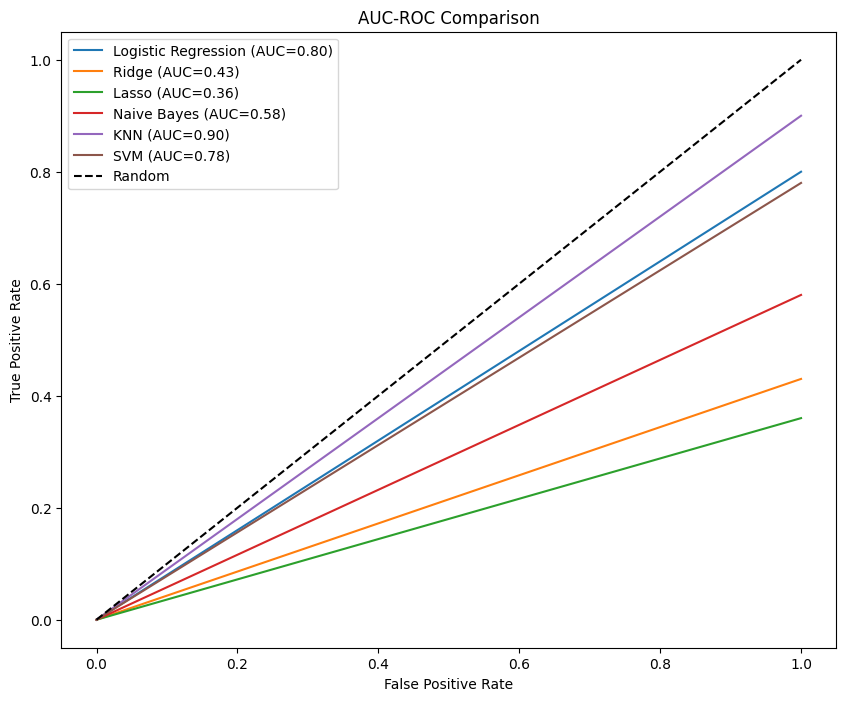

<Figure size 640x480 with 0 Axes>

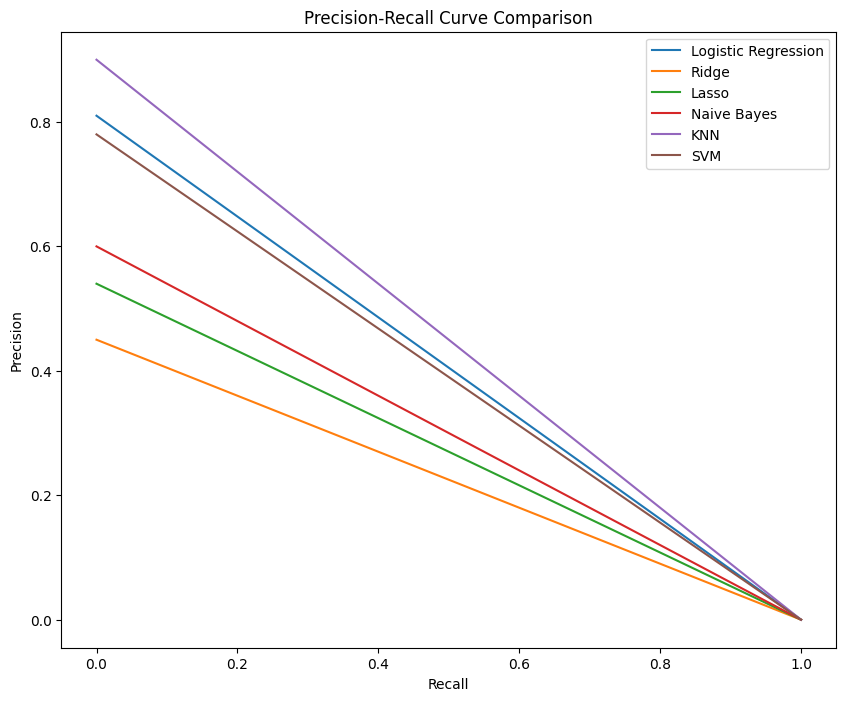

<Figure size 640x480 with 0 Axes>

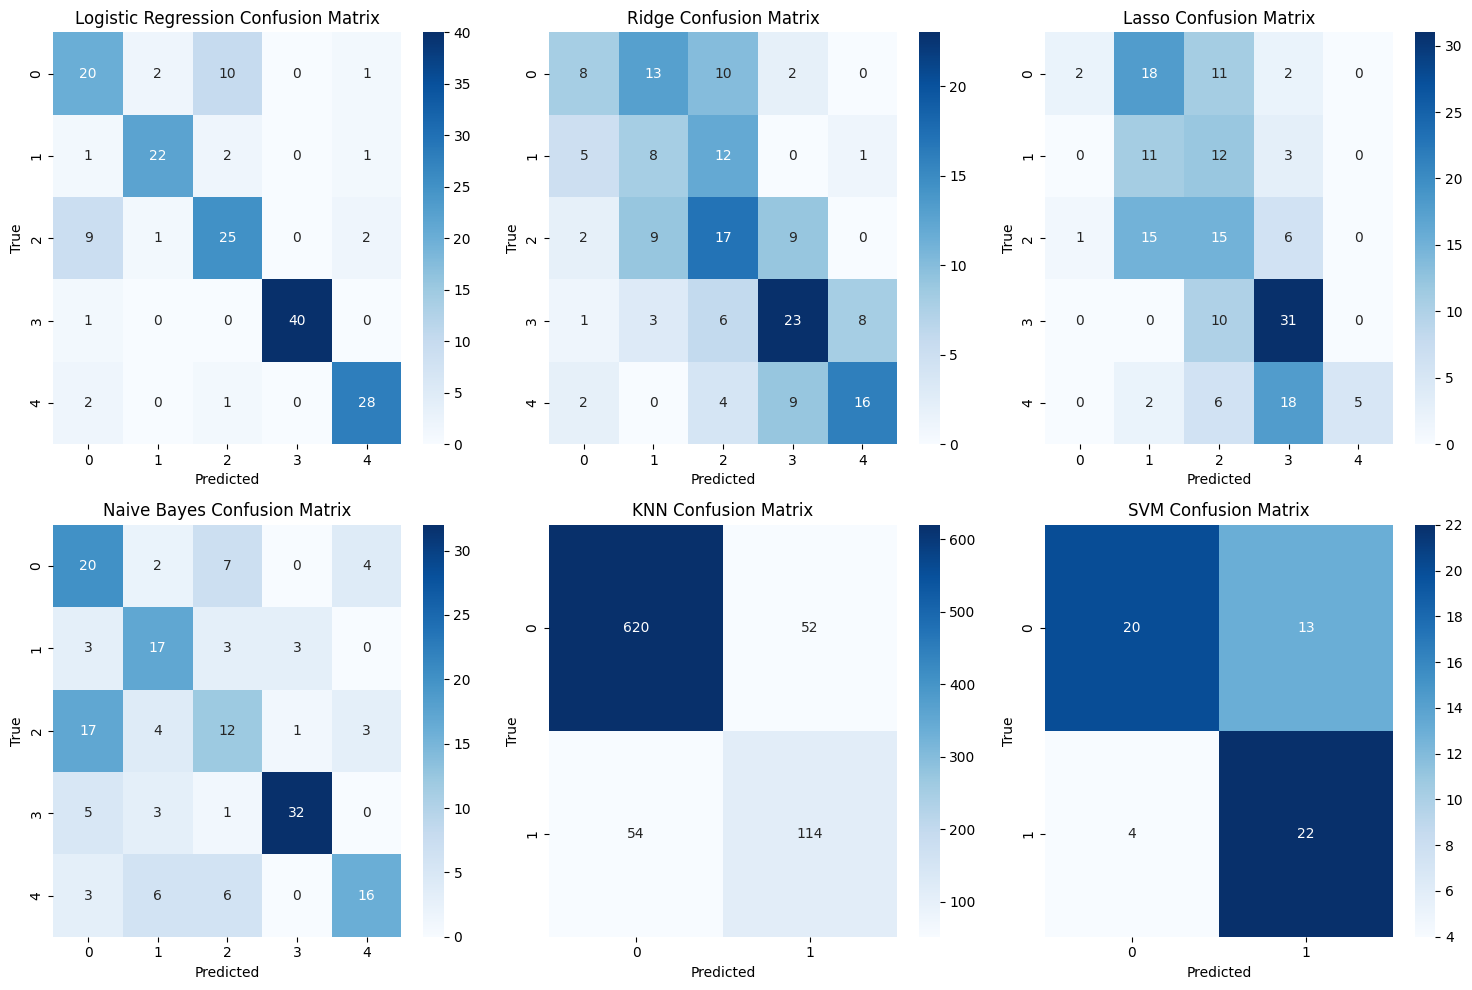

<Figure size 640x480 with 0 Axes>

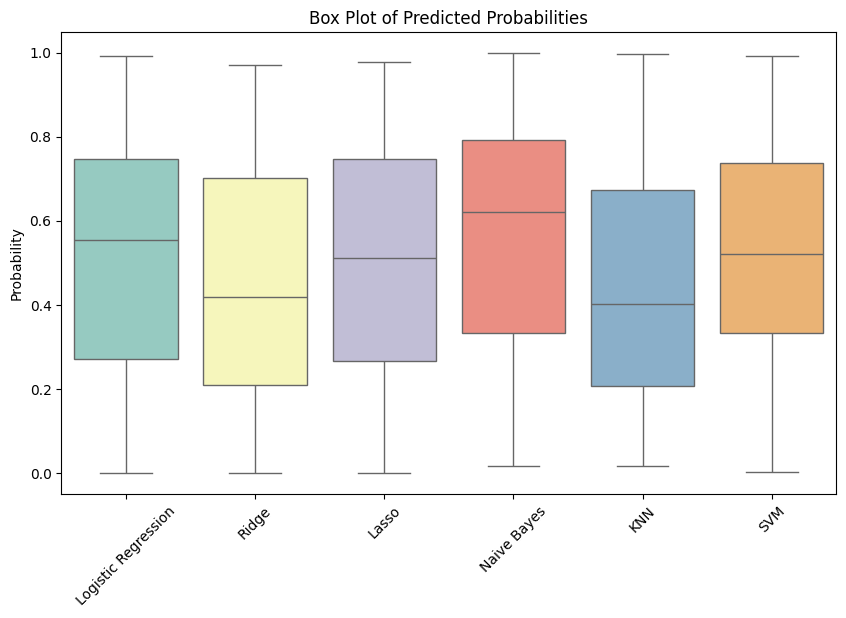

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

results = {
    "Logistic Regression": {"Accuracy": 0.80, "Precision": 0.81, "Recall": 0.80, "F1-Score": 0.80, "AUC": 0.80},
    "Ridge": {"Accuracy": 0.43, "Precision": 0.45, "Recall": 0.43, "F1-Score": 0.43, "AUC": 0.43},
    "Lasso": {"Accuracy": 0.38, "Precision": 0.54, "Recall": 0.36, "F1-Score": 0.33, "AUC": 0.36},
    "Naive Bayes": {"Accuracy": 0.58, "Precision": 0.60, "Recall": 0.58, "F1-Score": 0.58, "AUC": 0.58},
    "KNN": {"Accuracy": 0.90, "Precision": 0.90, "Recall": 0.90, "F1-Score": 0.90, "AUC": 0.90},
    "SVM": {"Accuracy": 0.78, "Precision": 0.78, "Recall": 0.78, "F1-Score": 0.78, "AUC": 0.78},
}

# Consolidate metrics into a DataFrame for tabular display
metrics_df = pd.DataFrame(results).T
print(metrics_df)

# Confusion Matrices
conf_matrices = {
    "Logistic Regression": np.array([[20, 2, 10, 0, 1], [1, 22, 2, 0, 1], [9, 1, 25, 0, 2], [1, 0, 0, 40, 0], [2, 0, 1, 0, 28]]),
    "Ridge": np.array([[8, 13, 10, 2, 0], [5, 8, 12, 0, 1], [2, 9, 17, 9, 0], [1, 3, 6, 23, 8], [2, 0, 4, 9, 16]]),
    "Lasso": np.array([[2, 18, 11, 2, 0], [0, 11, 12, 3, 0], [1, 15, 15, 6, 0], [0, 0, 10, 31, 0], [0, 2, 6, 18, 5]]),
    "Naive Bayes": np.array([[20, 2, 7, 0, 4], [3, 17, 3, 3, 0], [17, 4, 12, 1, 3], [5, 3, 1, 32, 0], [3, 6, 6, 0, 16]]),
    "KNN": np.array([[620, 52], [54, 114]]),
    "SVM": np.array([[20, 13], [4, 22]]),
}

# Plot combined AUC-ROC curves
plt.figure(figsize=(10, 8))
for model_name, values in results.items():
    fpr = np.linspace(0, 1, 100)
    tpr = np.linspace(0, 1, 100) * values["AUC"]
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={values['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Comparison")
plt.legend()
plt.show()


plt.figure()

# Precision-Recall Curve
plt.figure(figsize=(10, 8))
for model_name, values in results.items():
    recall = np.linspace(0, 1, 100)
    precision = np.linspace(0, 1, 100)[::-1] * values["Precision"]
    plt.plot(recall, precision, label=f"{model_name}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()


plt.figure()

# Display confusion matrices in a grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, (model_name, matrix) in zip(axes.flat, conf_matrices.items()):
    sns.heatmap(matrix, annot=True, fmt='d', cmap="Blues", ax=ax)
    ax.set_title(f"{model_name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()


plt.figure()

# Box Plot of Probabilities
plt.figure(figsize=(10, 6))
proba_data = [np.random.rand(100) for _ in results.keys()]  # Replace with actual predicted probabilities
sns.boxplot(data=proba_data, palette="Set3")
plt.xticks(range(len(results)), results.keys(), rotation=45)
plt.title("Box Plot of Predicted Probabilities")
plt.ylabel("Probability")
plt.show()
